In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)


## Introduction

This report explores the trends and insights behind car sales, analyzing key factors like price, horsepower, fuel efficiency, and drive modes. By breaking down the data, we uncover what influences car pricing, how different features impact value, and what buyers should consider when making a purchase. Whether you’re looking for affordability, performance, or efficiency, this analysis provides actionable insights to help make informed decisions in the car market.

**Objective**

The goal of this exploratory data analysis (EDA) is to analyze a car sales dataset to uncover patterns, trends, and insights related to car specifications, fuel efficiency, and pricing.

### Prepare Data

#### Cleaning | Feature Enginerrring 

In [216]:
# define our data cleaning wrangle function
def wrangle(filename):
    df = pd.read_csv(filename)
    
    # drop unwanted columns
    df.drop(
        columns = ['Engine Fuel Type', 'Market Category', 'Vehicle Style', 'Popularity', 'Number of Doors', 'Vehicle Size'],
        inplace = True)

    # rename columns for best understanding
    df.rename(
        columns={"Engine HP": "HP", "Engine Cylinders": "Cylinders", "Transmission Type": "Transmission", "Driven_Wheels": "Drive_Mode","highway MPG": "MPG_H", "city mpg": "MPG_C", "MSRP": "Price" },
        inplace = True)
    
    # change price column to numerical 
    df['Price'] = (df['Price'].str.replace(',', '')).astype('int')
    
    # add the age of cars
    df['car_age'] = 2025 - df['Year']
    
    #change column names to lower case
    df.columns = [c.lower() for c in df.columns]

    #drop duplicates
    df.drop_duplicates(subset = ['make', 'model', 'hp', 'price'], inplace = True)

    #drop null values
    df.dropna(axis = 0, inplace = True)

    # Selecting only numeric columns
    numeric_df = df.select_dtypes(include=['number'])

    # OUTLIER REMOVAL
    q1 = numeric_df.quantile(0.25)
    q3 = numeric_df.quantile(0.75)
    iqr = q3 - q1

    # Creating bounds
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Filtering rows: Keep rows where all numeric values are within bounds
    mask = (numeric_df >= lower_bound) & (numeric_df <= upper_bound)
    df = df[mask.all(axis=1)]

    # reduce features in model, only 19 models and others 
    model_list = df['model'].value_counts().sort_values(ascending = False).head(19).keys().to_list()
    df['model'] = df['model'].apply(lambda x : x if x in model_list else 'Others')

    #reduce features in make also
    # make with counts above 100
    make_list = df['make'].value_counts().head(26).keys().to_list()
    df['make'] = df['make'].apply(lambda x: x if x in make_list else 'Others')

    #average mpg
    df['mpg'] = (df['mpg_h'] + df['mpg_c'])/2

    #segment price
    df['price_segment'] = df['price'].apply(lambda x: "Budget" if x <= 10_000_000 else "Mid-Range" if x < 30_000_000 else "Premium" if x < 50_000_000 else "Luxury")

    # segment car age
    df['age_segment'] = df['car_age'].apply(lambda x: "New" if x <= 9 else "Fairly New" if x <= 13 else "Used" if x <= 20 else "Old")

    #segment horse power
    df['hp_segment'] = df['hp'].apply(lambda x: "Economy" if x < 150 else "Standard" if x < 250 else "Performance" if x < 400 else "Sports")

    #segment fuel
    df['fuel_segment'] = df['mpg'].apply(lambda x: "Gas guzzler" if x < 20 else "Average" if x <= 25 else "Efficient")

    return df

In [218]:
df =  wrangle('data.csv')
print(f'Dataset: {df.shape[0]} rows and {df.shape[1]} columns')
print(f'Dataset size: {df.size} ')
df.head()

Dataset: 8286 rows and 16 columns
Dataset size: 132576 


,make,model,year,hp,cylinders,transmission,drive_mode,mpg_h,mpg_c,price,car_age,mpg,price_segment,age_segment,hp_segment,fuel_segment
0,BMW,Others,2011,335.0,6.0,MANUAL,rear wheel drive,26,19,46135000,14,22.5,Premium,Used,Performance,Average
1,BMW,Others,2011,300.0,6.0,MANUAL,rear wheel drive,28,19,40650000,14,23.5,Premium,Used,Performance,Average
2,BMW,Others,2011,300.0,6.0,MANUAL,rear wheel drive,28,20,36350000,14,24.0,Premium,Used,Performance,Average
3,BMW,Others,2011,230.0,6.0,MANUAL,rear wheel drive,28,18,29450000,14,23.0,Mid-Range,Used,Standard,Average
4,BMW,Others,2011,230.0,6.0,MANUAL,rear wheel drive,28,18,34500000,14,23.0,Premium,Used,Standard,Average


In [220]:
df.columns

Index(['make', 'model', 'year', 'hp', 'cylinders', 'transmission',
       'drive_mode', 'mpg_h', 'mpg_c', 'price', 'car_age', 'mpg',
       'price_segment', 'age_segment', 'hp_segment', 'fuel_segment'],
      dtype='object')

In [222]:
# explore number columns in dataset
nums = df.select_dtypes('number').nunique()
nums

year           22
hp            233
cylinders       5
mpg_h          30
mpg_c          23
price        5057
car_age        22
mpg            52
dtype: int64

In [224]:
# explore categorical features
objects = df.select_dtypes('object').nunique()
objects

make             27
model            20
transmission      4
drive_mode        4
price_segment     4
age_segment       4
hp_segment        4
fuel_segment      3
dtype: int64

In [226]:
# find the null values in our dataset
df.isnull().sum().sum()

0

**Outlier detection**

The outlier detection and removing that I am going to perform is called IQR score technique. Often outliers can be seen with visualizations using a box plot. Shown below are the box plot of all the numerical features in our dataset. Herein all the plots, the points that lie outside the box are none other than outliers. In car sales year, the outlier lies from 1995 or earlier, this means that older cars would not contribute much insight to our analysis, so they are okay to drop

This method of outlier detection is refresnced to the [Khan Academy lesson](https://www.khanacademy.org/math/statistics-probability/summarizing-quantitative-data/box-whisker-plots/a/identifying-outliers-iqr-rule) lesson

In [230]:
# nums_cols = df.select_dtypes('number').nunique().keys().to_list()
# for i in nums_cols:
#     fig, ax = plt.subplots(figsize = (6,3))
#     df[i].plot(kind = 'box', vert = False, ax = ax)
#     plt.show()

## Explore

In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8286 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   make           8286 non-null   object 
 1   model          8286 non-null   object 
 2   year           8286 non-null   int64  
 3   hp             8286 non-null   float64
 4   cylinders      8286 non-null   float64
 5   transmission   8286 non-null   object 
 6   drive_mode     8286 non-null   object 
 7   mpg_h          8286 non-null   int64  
 8   mpg_c          8286 non-null   int64  
 9   price          8286 non-null   int32  
 10  car_age        8286 non-null   int64  
 11  mpg            8286 non-null   float64
 12  price_segment  8286 non-null   object 
 13  age_segment    8286 non-null   object 
 14  hp_segment     8286 non-null   object 
 15  fuel_segment   8286 non-null   object 
dtypes: float64(3), int32(1), int64(4), object(8)
memory usage: 1.0+ MB


In [235]:
df.describe()

,year,hp,cylinders,mpg_h,mpg_c,price,car_age,mpg
count,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,8.286000e+03,8286.000000,8286.000000
mean,2011.717958,238.749578,5.458001,26.434106,19.257784,3.176542e+07,13.282042,22.845945
std,5.683674,75.702082,1.401046,5.793713,4.431077,1.426289e+07,5.683674,5.037992
min,1996.000000,79.000000,3.000000,13.000000,10.000000,2.000000e+06,8.000000,11.500000
25%,2008.000000,178.000000,4.000000,22.000000,16.000000,2.279500e+07,9.000000,19.000000
50%,2015.000000,237.000000,6.000000,26.000000,18.000000,3.041250e+07,10.000000,22.000000
75%,2016.000000,290.000000,6.000000,30.000000,22.000000,4.004875e+07,17.000000,26.000000
max,2017.000000,485.000000,8.000000,42.000000,32.000000,7.469500e+07,29.000000,37.000000


In [237]:
(df['price'].describe()).apply(lambda x: f"{x:,.2f}")


count         8,286.00
mean     31,765,417.69
std      14,262,891.26
min       2,000,000.00
25%      22,795,000.00
50%      30,412,500.00
75%      40,048,750.00
max      74,695,000.00
Name: price, dtype: object

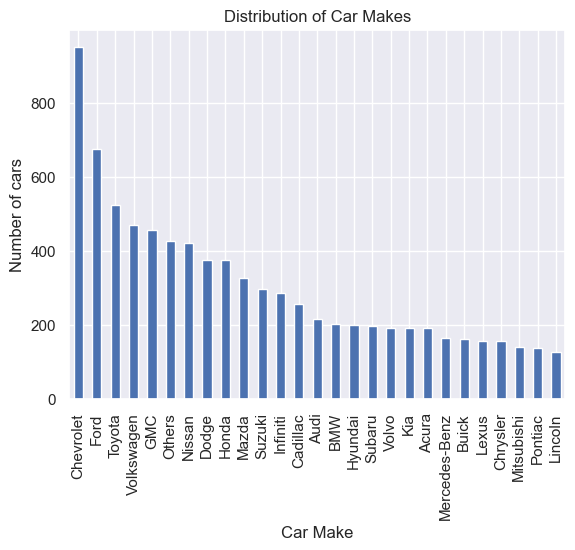

In [239]:
df['make'].value_counts().plot(kind = 'bar')
plt.title('Distribution of Car Makes')
plt.xlabel('Car Make')
plt.ylabel('Number of cars');

The distribution of car makes shows that a few brands dominate the dataset, with Chevrolet being the most common. This suggests that certain manufacturers have a larger market presence, likely due to affordability, reliability, or brand preference. Meanwhile, less frequent makes may represent niche or luxury brands with lower overall sales. The imbalance in distribution could also indicate market trends favoring specific manufacturers.

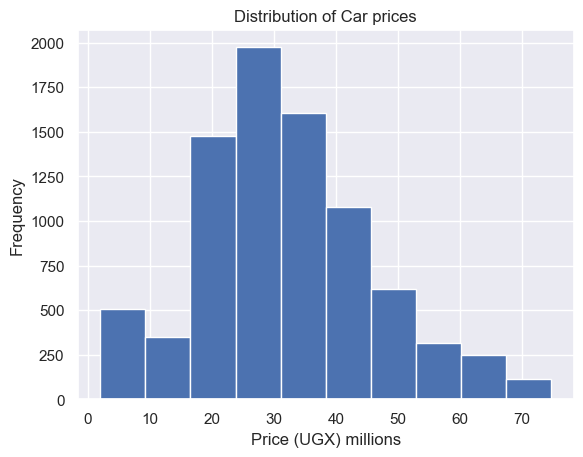

In [242]:
(df['price']/1e6).plot(kind = 'hist')
plt.title('Distribution of Car prices')
plt.xlabel('Price (UGX) millions')
plt.ylabel('Frequency');

The histogram shows the distribution of car prices, revealing that most vehicles fall within the mid-range price category (UGX 20M-40M). The distribution appears right-skewed, indicating that while a few luxury cars exceed or equals to UGX 50M, the majority of listings are in the mid range to premium segment."

Some of the budget cars in the listing includes cars are Ford, Chevrolet, Mazda, GMC and others

Options in the mid range and premium segment includes Chevrolet, Ford, Toyota, Volkswagen, Nissan

In the luxury section, some of the clasy cars are found in the Cadillac, Mercedes-Benz, Chevrolet, BMW, Audi makes



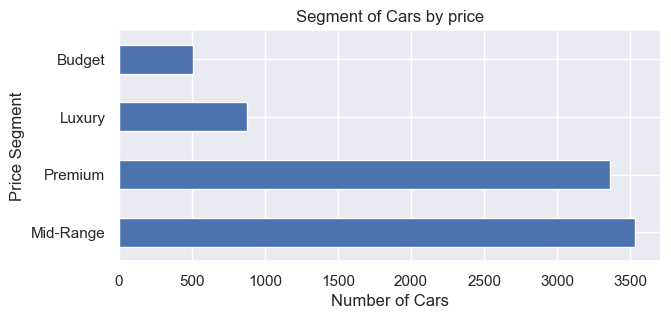

In [245]:
df.price_segment.value_counts().plot(kind = 'barh', rot = 0, figsize = (7,3));
plt.xlabel('Number of Cars')
plt.ylabel('Price Segment')
plt.title('Segment of Cars by price');

In [247]:
df[(df['price_segment'] =='Luxury')]['make'].value_counts().head(5).keys().to_list()

['Cadillac', 'Mercedes-Benz', 'Chevrolet', 'BMW', 'Audi']

In [249]:
df[(df['price_segment'] =='Premium') | (df['price_segment'] == 'Mid-Range')]['make'].value_counts().head(5).keys().to_list()

['Chevrolet', 'Ford', 'Toyota', 'Volkswagen', 'Nissan']

In [251]:
df[(df['price_segment'] =='Budget')]['make'].value_counts().head(5).keys().to_list()

['Ford', 'Chevrolet', 'Others', 'Mazda', 'GMC']

### Car Price Vs Car Age

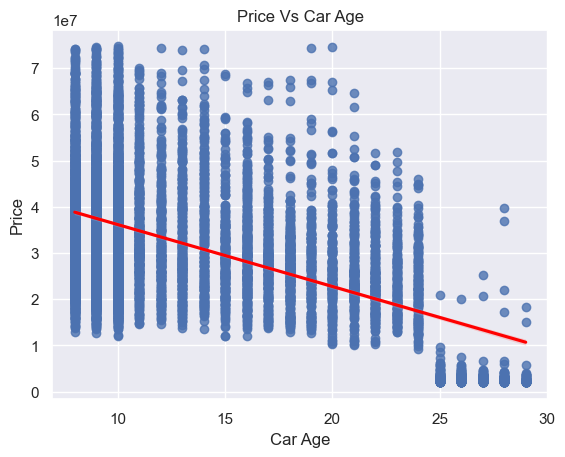

In [254]:
sns.regplot(df, x = 'car_age', y = 'price', line_kws={"color": "red"})
plt.xlabel('Car Age')
plt.ylabel('Price')
plt.title('Price Vs Car Age');

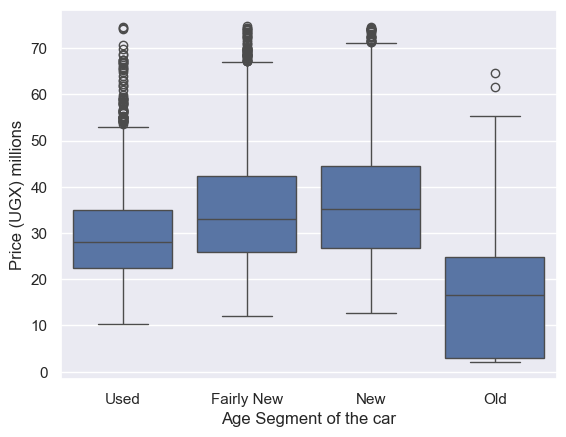

In [255]:
sns.boxplot(x = df['age_segment'], y = df['price']/1e6)
plt.xlabel('Age Segment of the car')
plt.ylabel('Price (UGX) millions');

The relationship between car price and age shows a clear depreciation trend—newer cars tend to have higher prices, while older vehicles lose value over time. Most cars above 25 years old rarely sell for more than UGX 10M, indicating a steep decline in value as they age. However, some exceptions exist, likely due to classic or high-performance models retaining their worth.

Some of the popular used cars are in the listing are Chevrolet, Dodge, Suzuki, Ford, Infiniti

If you are on a budget, some popular old cars include the following Chevrolet, Ford, Mazda, GMC and others

The new and faily new cars available are Chevrolet, Toyota, Ford, Volkswagen, Nissan


In [259]:
df[(df['age_segment'] =='Used')]['make'].value_counts().head(5).keys().to_list()

['Chevrolet', 'Dodge', 'Suzuki', 'Ford', 'Infiniti']

In [261]:
df[(df['age_segment'] =='Old')]['make'].value_counts().head(5).keys().to_list()

['Chevrolet', 'Ford', 'Others', 'Mazda', 'GMC']

In [263]:
df[(df['age_segment'] =='New') | (df['age_segment'] == 'Fairly New')]['make'].value_counts().head(5).keys().to_list()

['Chevrolet', 'Toyota', 'Ford', 'Volkswagen', 'Nissan']

### Car Price vs Horse Power

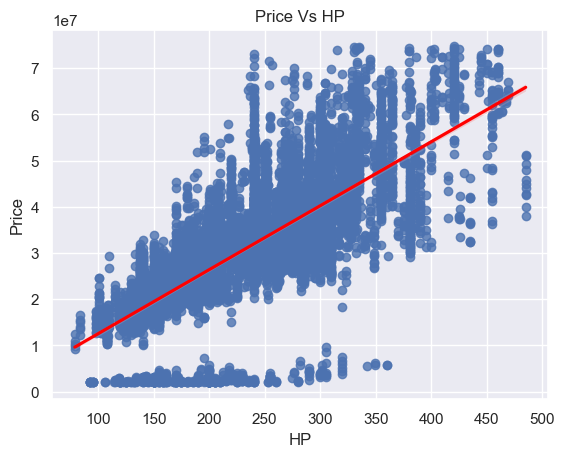

In [266]:
sns.regplot(df, x = 'hp', y = 'price', line_kws={"color": "red"})
plt.xlabel('HP')
plt.ylabel('Price')
plt.title('Price Vs HP');

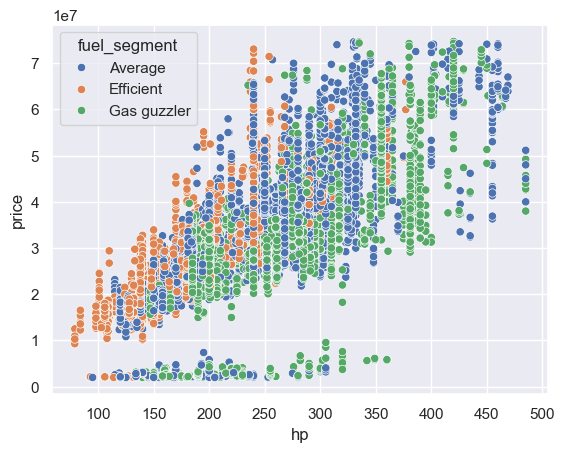

In [267]:
sns.scatterplot(df, x = 'hp', y = 'price', hue = 'fuel_segment');

The analysis of horsepower (HP) and price reveals a positive correlation—cars with higher HP generally command higher prices. This trend suggests that performance-oriented vehicles, such as Chevrolet, Cadillac, Infiniti, BMW, Mercedes-Benz, are priced at a premium. In contrast, lower-HP vehicles, typically economy or standard models, tend to be more affordable. However, some variations exist, likely influenced by factors such as brand, model, and additional features.

In the performance section, Chevrolet, Ford, GMC, Toyota, Nissan takes up the chart while the classy sports makes are availble in Chevrolet, Cadillac, Infiniti, BMW, Mercedes-Benz

For the best horse power and mid range price, customers can go for a Toyota, Dodge, Chevrolet or a Ford

In [271]:
df[(df['hp'] >= 350) & (df['price'] <= 4e7)]['make'].value_counts().keys().to_list()

['Toyota', 'Dodge', 'Chevrolet', 'Ford', 'Pontiac', 'Nissan', 'GMC', 'Lincoln']

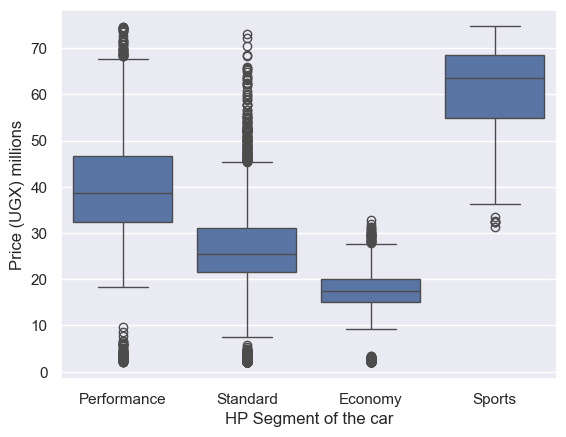

In [273]:
sns.boxplot(x = df['hp_segment'], y = df['price']/1e6)
plt.xlabel('HP Segment of the car')
plt.ylabel('Price (UGX) millions');

In [102]:
df[(df['hp_segment'] =='Performance')]['make'].value_counts().head(5).keys().to_list()

['Chevrolet', 'Ford', 'GMC', 'Toyota', 'Nissan']

In [103]:
df[df['hp_segment'] == 'Sports']['make'].value_counts().head(5).keys().to_list()

['Chevrolet', 'Cadillac', 'Infiniti', 'BMW', 'Mercedes-Benz']

### Car price vs Drive mode

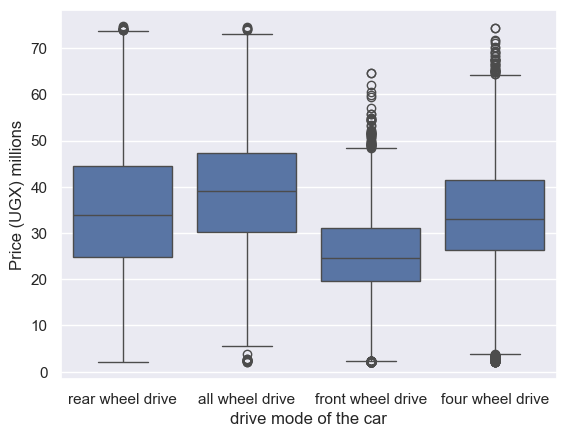

In [105]:
sns.boxplot(x = df['drive_mode'], y = df['price']/1e6)
plt.xlabel('drive mode of the car')
plt.ylabel('Price (UGX) millions');

Front-wheel drive (FWD) cars are generally the cheapest, with a lower median price and fewer high-end outliers, making them a budget-friendly option. On the other hand, all-wheel drive (AWD) and rear-wheel drive (RWD) cars tend to be more expensive, likely due to their performance and handling advantages. Four-wheel drive (4WD) vehicles also have a higher price range, which makes sense since they're built for off-road capability. If you're looking for affordability, FWD is the way to go. But if performance, traction, or off-road ability matter to you, expect to pay more for AWD, RWD, or 4WD options.

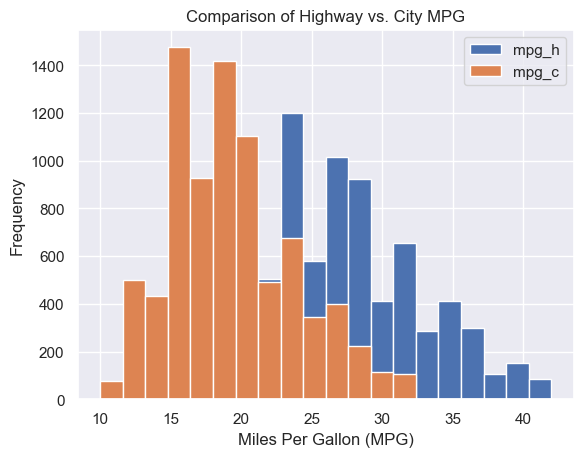

In [107]:
df[['mpg_h', 'mpg_c']].plot(kind = 'hist', bins = 20)
plt.xlabel("Miles Per Gallon (MPG)")
plt.ylabel("Frequency")
plt.title("Comparison of Highway vs. City MPG");

We can see that we burn more fuel in the city than on the highway

If you're looking to save on fuel, keep in mind that city driving burns more gas than highway driving. The constant stopping, braking, and idling in traffic make your car work harder, meaning fewer miles per gallon. On the highway, it's a different story—steady speeds and fewer stops let your engine run more efficiently, stretching your fuel further. So, if most of your driving is in the city, a fuel-efficient car might save you a lot in the long run

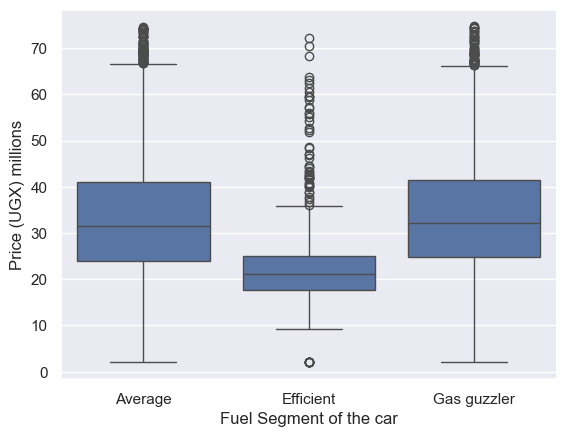

In [109]:
sns.boxplot(x = df['fuel_segment'], y = df['price']/1e6)
plt.xlabel('Fuel Segment of the car')
plt.ylabel('Price (UGX) millions');

This box plot shows how car prices vary across different fuel efficiency categories. Efficient cars are generally the cheapest, with a lower median price and fewer high-priced outliers. On the other hand, gas guzzlers and average cars have a much wider price range, meaning you’ll find both affordable and high-end options. The fact that gas guzzlers and average cars have more outliers suggests that some performance or luxury models push prices way up. Basically, if you're after a budget-friendly option, efficient cars are your best bet. But if you're looking for power and don’t mind spending more, gas guzzlers dominate the high-end market.

### Horse power and Fuel

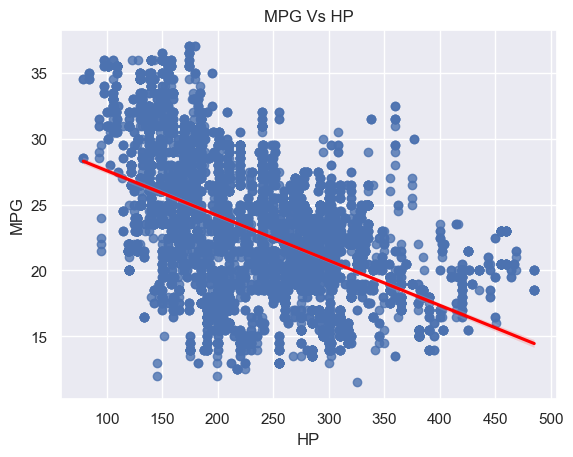

In [112]:
sns.regplot(df, x = 'hp', y = 'mpg', line_kws={"color": "red"})
plt.xlabel('HP')
plt.ylabel('MPG')
plt.title('MPG Vs HP');

Not only are cars with high horse power (HP) expensive but they are also very expensive in fuel, cars with lower horse power tends to go longer miles per gallon compared to cars with higher horse power. However there are a few cars with good horse power and some efficient fuel consumption. These cars include the Infiniti, Mercedes-Benz and the Acura

In [114]:
df[(df['mpg'] >= 25) & (df['hp'] >= 350)]['make'].value_counts().keys().to_list()

['Infiniti', 'Mercedes-Benz', 'Acura']

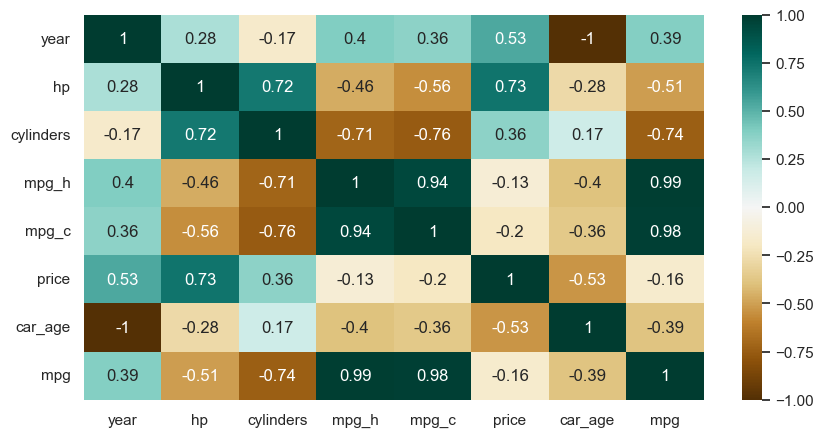

In [115]:
plt.figure(figsize=(10,5))
c= df.select_dtypes('number').corr()
sns.heatmap(c,cmap="BrBG",annot=True);

Generally, the heatmap shows how different features in the dataset relate to each other. As expected, car age and price have a strong negative correlation—older cars tend to be cheaper. On the other hand, horsepower has a positive correlation with price, meaning high-performance cars usually cost more. There are also some interesting patterns, like the trade-off between HP and fuel efficiency (MPG). Overall, the heatmap gives a quick snapshot of how these factors interact and what really drives car pricing.

## Conclusion

From this analysis, it’s clear that multiple factors influence car prices, including age, horsepower, fuel efficiency, and drive mode. Older cars tend to be more affordable, while high-performance and fuel-hungry models command higher prices. Fuel-efficient cars are generally the most budget-friendly, whereas AWD and 4WD vehicles cater to those willing to pay for better traction and off-road capability. These insights can help buyers, dealerships, and industry professionals make smarter choices when navigating the car market.